<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/aml_2324_w2_poly_feat_eng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AML 23/24 Week 2: Polynomial and Interaction Features

* We addressed high variance; not we will address high bias

* There is so much one can do with a straight line/surface; works well in some contexts; lacks flexibility; good interpretability

* In many cases we would rather have a curved line/surface...

* Key idea: transform the data space, rather than the technique.



## Importing and Configuring

In [ ]:
# latest version of sklearn (to have access to recent features)
!pip install --upgrade scikit-learn==1.4.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 31.4 MB/s eta 0:00:00


In [ ]:
import sklearn
# this makes is easier for getting dataframes by default as input/output of
# sklearn pipelines
sklearn.set_config(transform_output="pandas")

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set(
    { "figure.figsize": (6, 4) },
    style='ticks',
    color_codes=True,
    font_scale=0.8
)
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge

## Fish Data and Polynomial Feature Engineering

### The Dataset

Example from DataCamp's Introduction to Linear Regression with `statsmodels`.

In [ ]:
fish = pd.read_csv('https://raw.githubusercontent.com/gerberl/6G7V0017-2324/main/datasets/fish.csv')

In [ ]:
fish.head()

,species,mass_g,length_cm
0,Bream,242.0,23.2
1,Bream,290.0,24.0
2,Bream,340.0,23.9
3,Bream,363.0,26.3
4,Bream,430.0,26.5


In [ ]:
fish.groupby('species')['mass_g'].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
Bream,35.0,617.828571,209.205709,242.0,462.50,610.0,717.00,1000.0
Perch,56.0,382.239286,347.617717,5.9,120.00,207.5,692.50,1100.0
Pike,17.0,718.705882,494.140765,200.0,345.00,510.0,950.00,1650.0
Roach,20.0,152.050000,88.828916,0.0,104.25,147.5,171.75,390.0


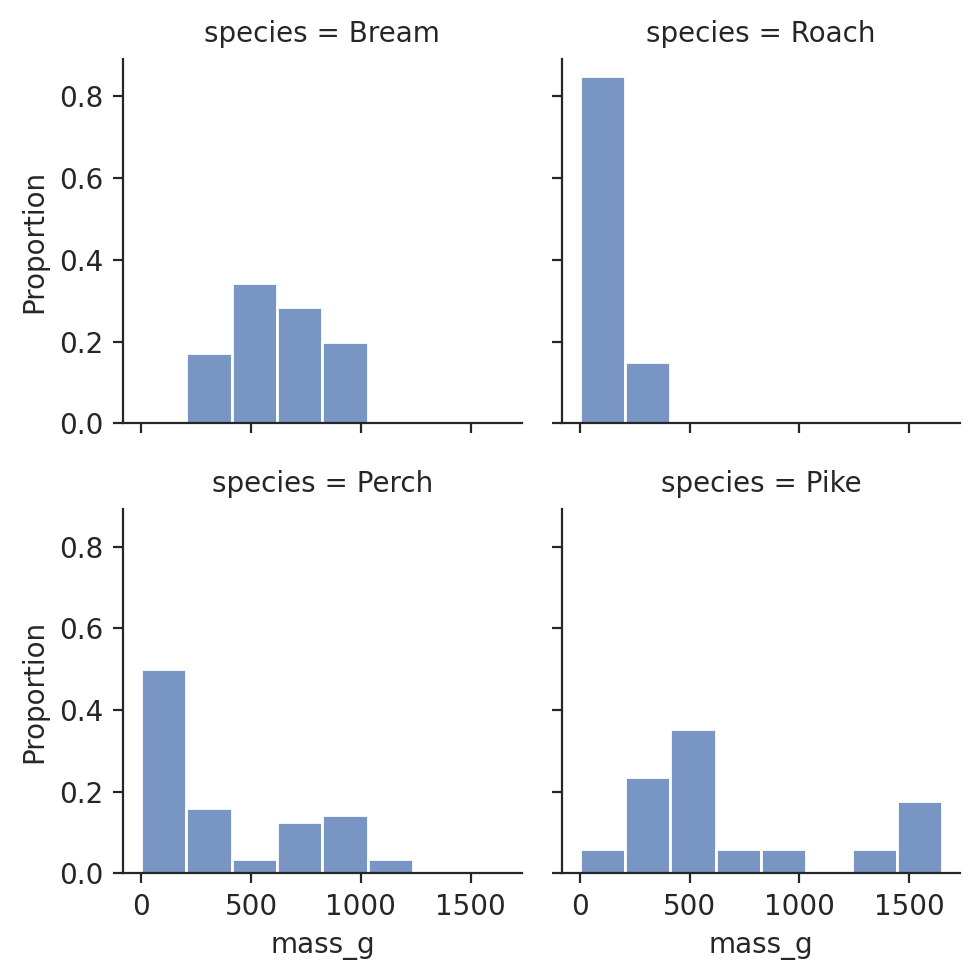

In [ ]:
sns.displot(
    data=fish, x='mass_g', col='species', col_wrap=2, height=2.5,
    stat='proportion', common_norm=False
);

### Regressing Mass on Length (Bream)

In [ ]:
bream = fish.query("species == 'Bream'")

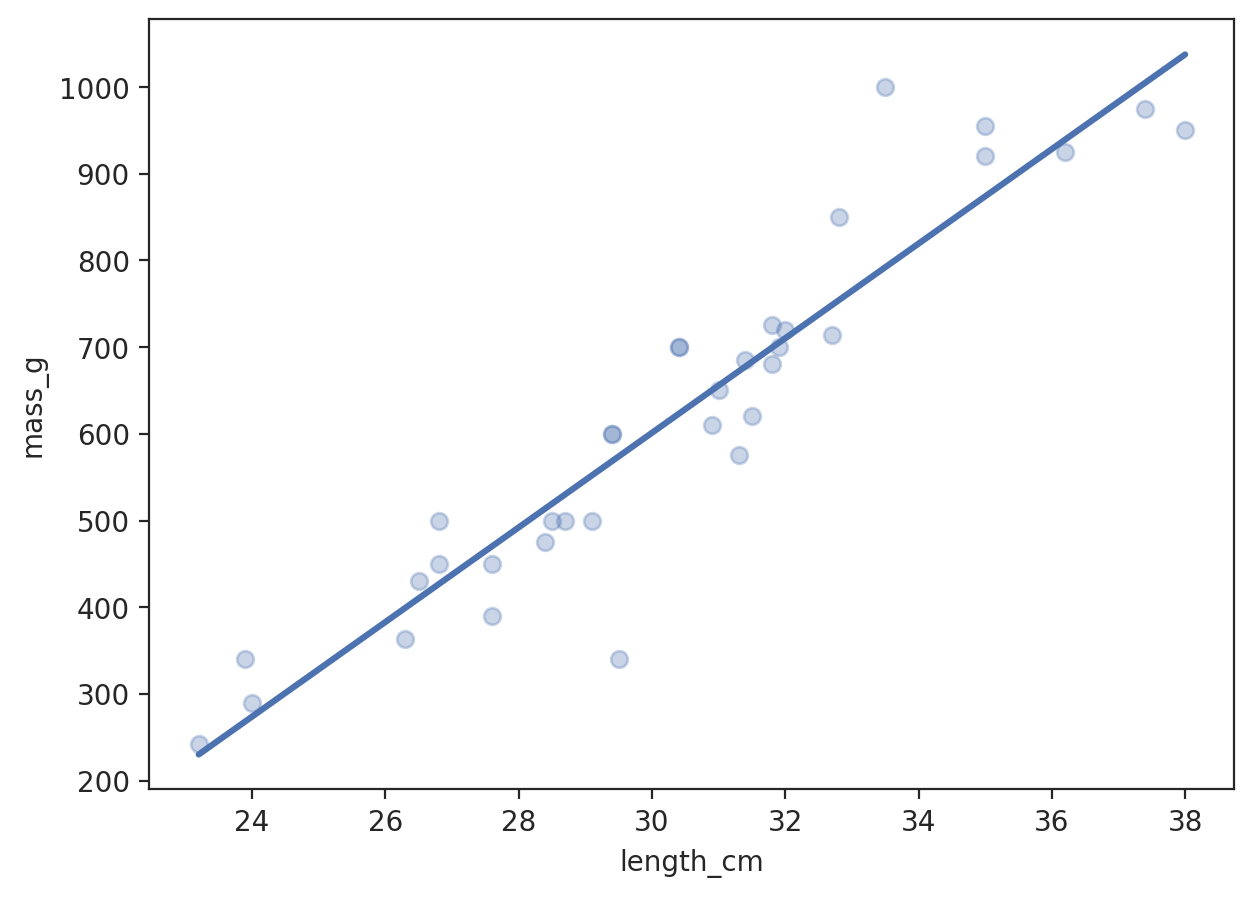

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(
    data=bream, x='length_cm', y='mass_g',
    scatter_kws=dict(alpha=0.3), ax=ax, ci=None
);

## Regressing Mass on Length (Perch)

In [ ]:
perch = fish.query("species == 'Perch'")

Simple linear model on `length`.

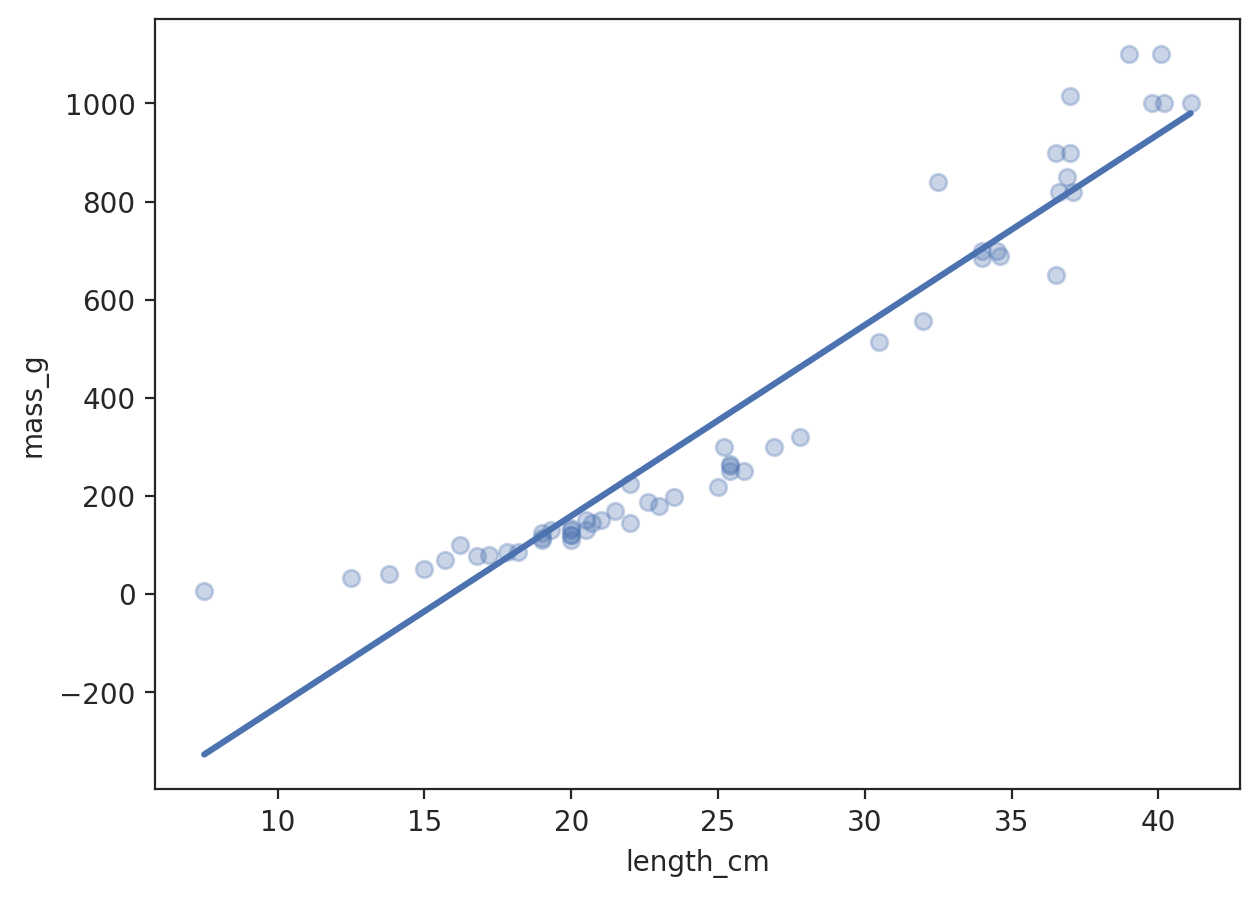

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(
    data=perch, x='length_cm', y='mass_g',
    scatter_kws=dict(alpha=0.3), ax=ax, ci=None
);

Scatter plot indicates that a non-linear model might to a better job at fitting the data. Let us ask `seaborn` to fit
a **second order** equation (e.g., $y = x^2$), which basically means a **quadratic curve** based on length. Now, instead of a straight line, we are trying to fit a parabola to the data, using the **model parameters** (e.g., coefficients) to shape it in a useful way for the data we have.

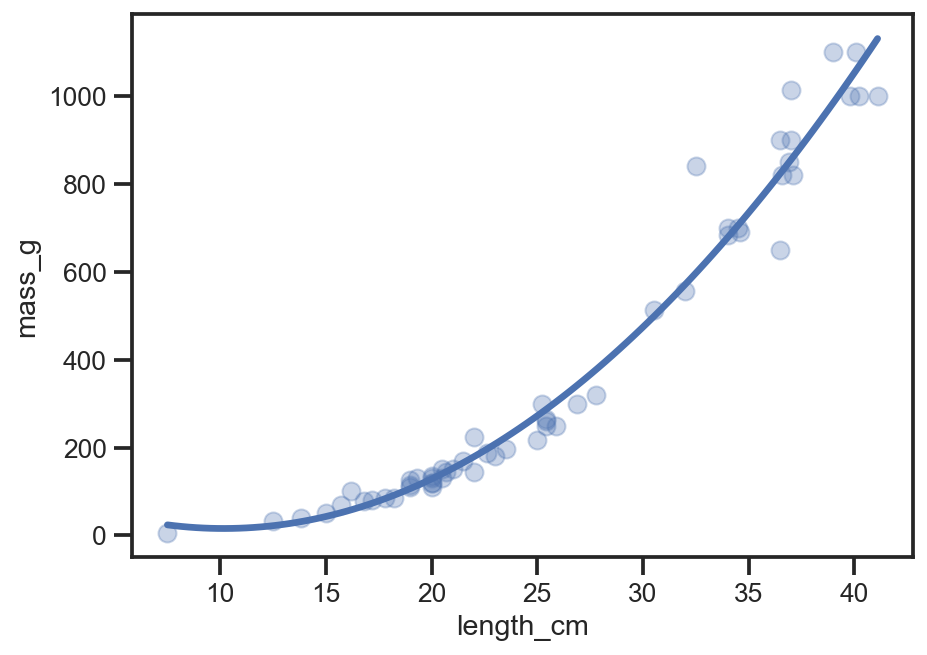

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(
    data=perch, x='length_cm', y='mass_g', order=2,
    scatter_kws=dict(alpha=0.3), ax=ax, ci=None
);

We can do the same with a third order for a more complex curve, and so on (you get the idea). Again, we are navigating that **underfitting / just right / overfitting space**. A straight line might be too simple and underfit, but a (say) 7th-degree equation might just follow the training data too closely.

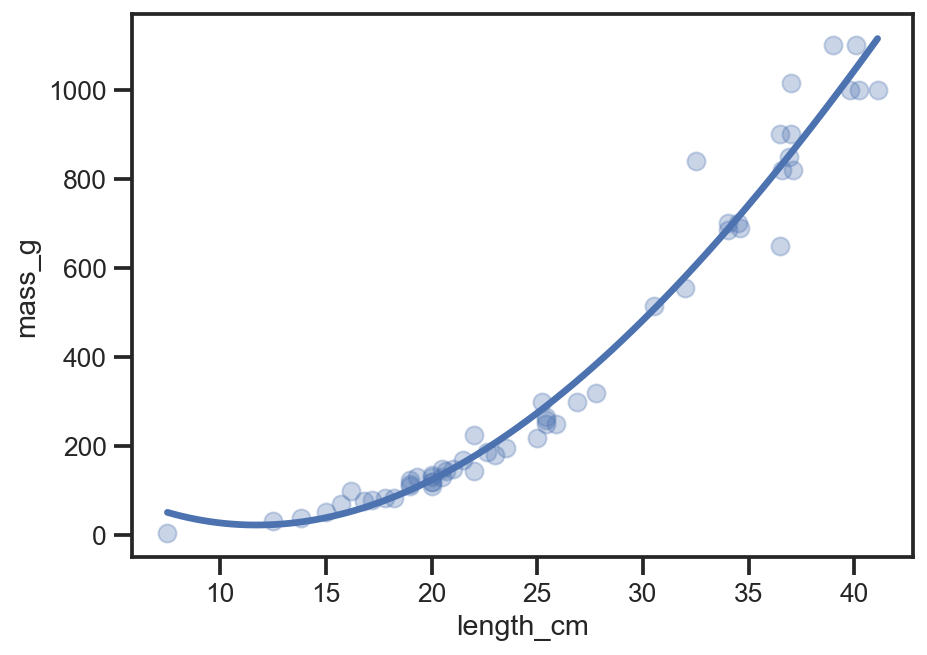

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(
    data=perch, x='length_cm', y='mass_g', order=3,
    scatter_kws=dict(alpha=0.3), ax=ax, ci=None
);

### Polynomial Regression is Really Just Data Transformation

In practice, we are still doing linear regression, but on a transformation of the original data space.

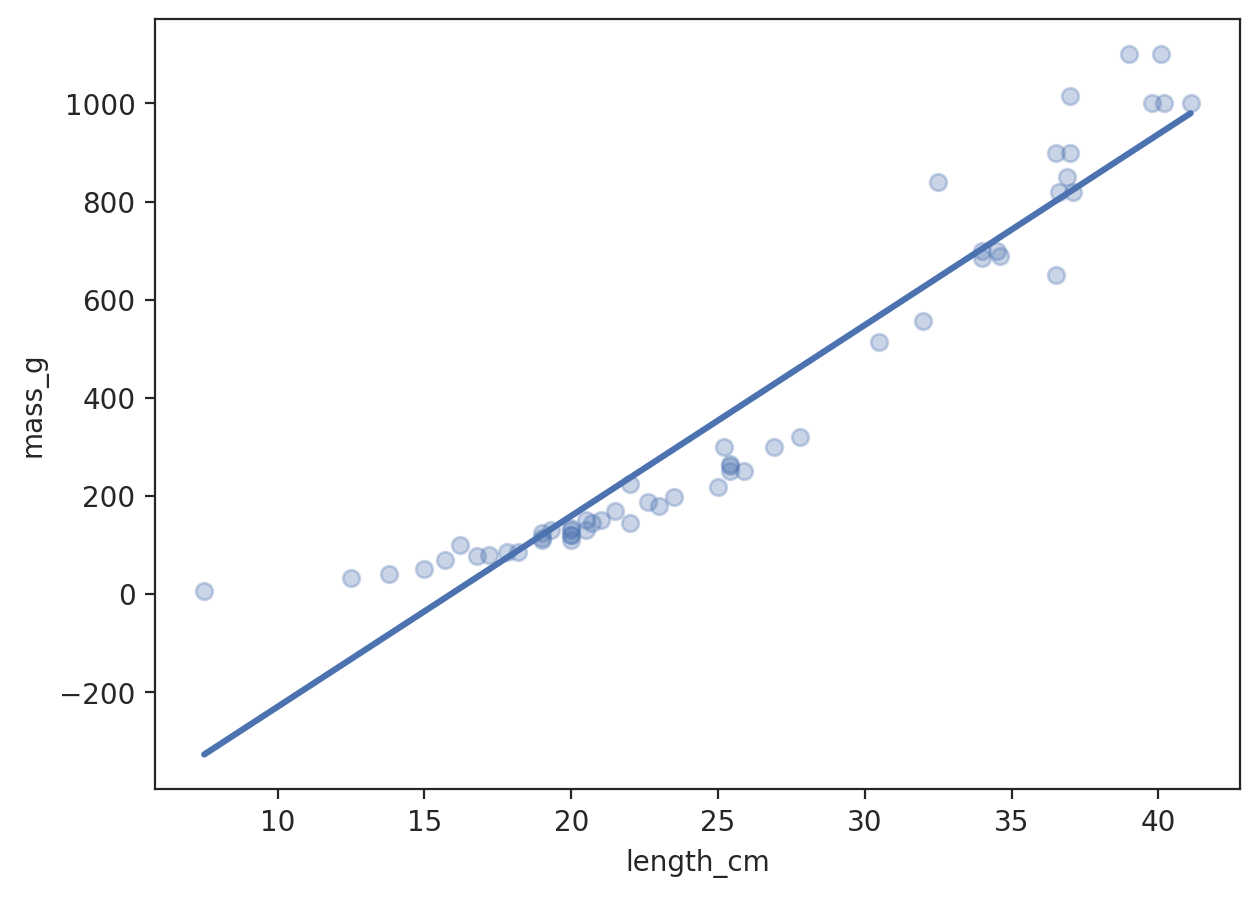

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(
    data=perch, x='length_cm', y='mass_g',
    scatter_kws=dict(alpha=0.3), ax=ax, ci=None
);

* Perch: is **fish volume** a better predictor for mass? (we should have a look at some photos of perch and bream...)

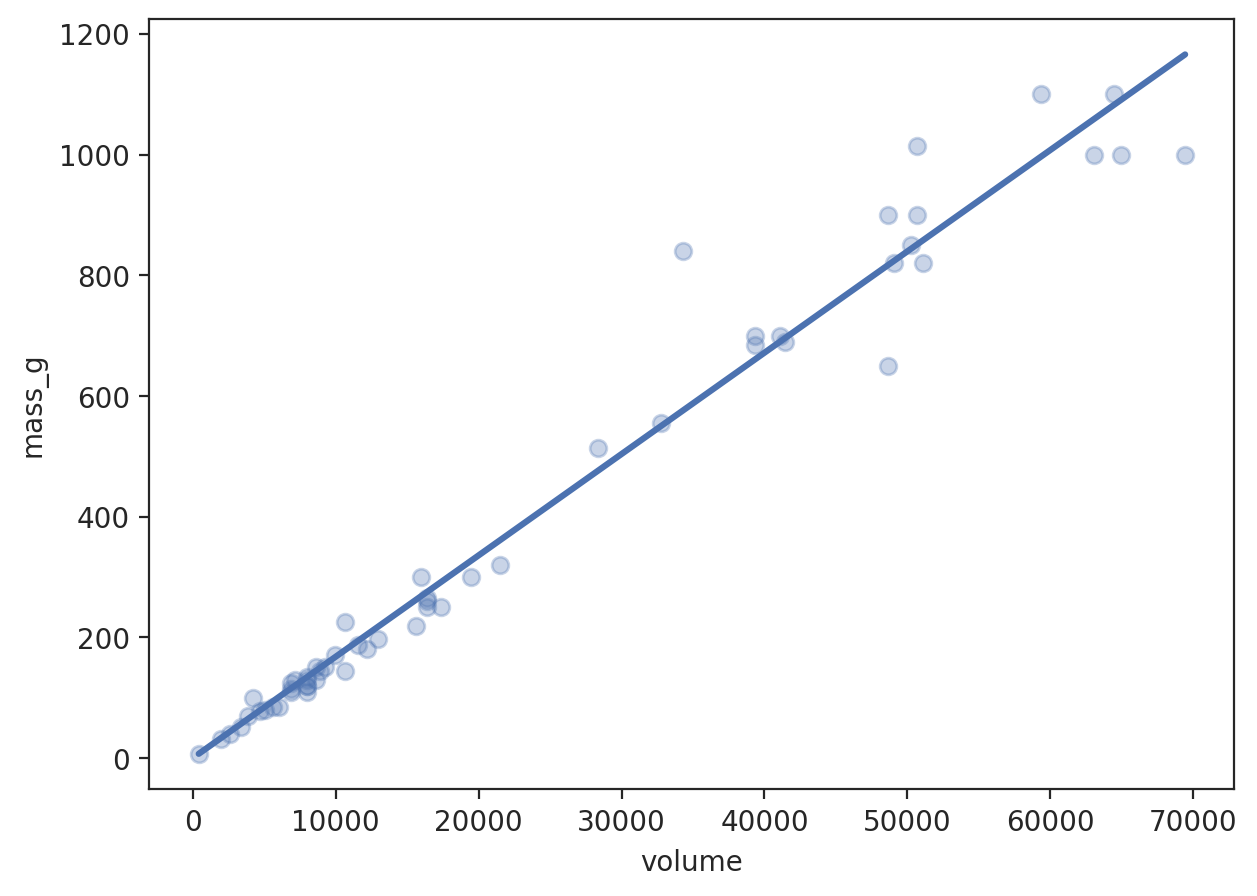

In [ ]:
perch_aug = perch.assign(volume=perch['length_cm']**3)
fig, ax = plt.subplots(figsize=(7,5))
sns.regplot(
    data=perch_aug, x='volume', y='mass_g',
    scatter_kws=dict(alpha=0.3), ax=ax, ci=None
);

The key idea of polynomial regression is the system will generate the polynomial features from the original data; the data space is modified; a simple model might now be a good fit to the (modified) data space.

## `sklearn` Can Generate Polynomial Features

In [ ]:
X, y = perch[['length_cm']], perch['mass_g']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
PolynomialFeatures((3, 3), include_bias=False).fit_transform(X_train).head()

,length_cm^3
90,19465.109
64,6028.568
107,63044.792
84,15625.000
87,16387.064


### How Does Normal Compare to Polynomial Regression?

In [ ]:
normal_reg = Pipeline(
    steps=[
        ('est', LinearRegression())
    ]
)

poly_reg = Pipeline(
    steps=[
        ('poly', PolynomialFeatures((3, 3), include_bias=False)),
        ('est', LinearRegression())
    ]
)

In [ ]:
normal_reg.fit(X_train, y_train)

Pipeline(steps=[('est', LinearRegression())])

In [ ]:
# for plotting the model prediction, some test data points
# only one feature
x_pred_range = pd.DataFrame(
    np.linspace(perch['length_cm'].min(), perch['length_cm'].max(), 1000),
    columns=['length_cm']
)

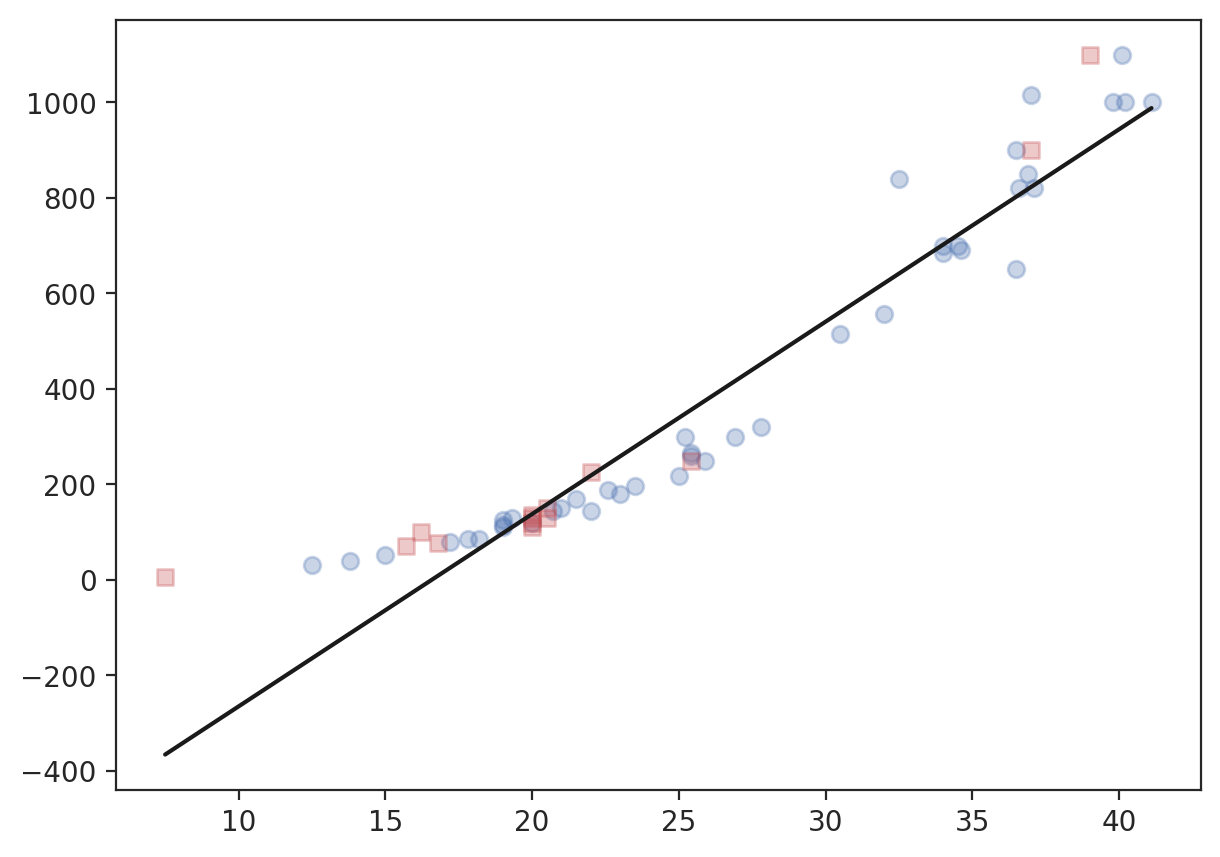

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train, y_train, alpha=0.3, marker='o', c='b')
ax.scatter(X_test, y_test, alpha=0.3, marker='s', c='r')
ax.plot(x_pred_range['length_cm'], normal_reg.predict(x_pred_range), c='k');

In [ ]:
poly_reg.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=(3, 3), include_bias=False)),
                ('est', LinearRegression())])

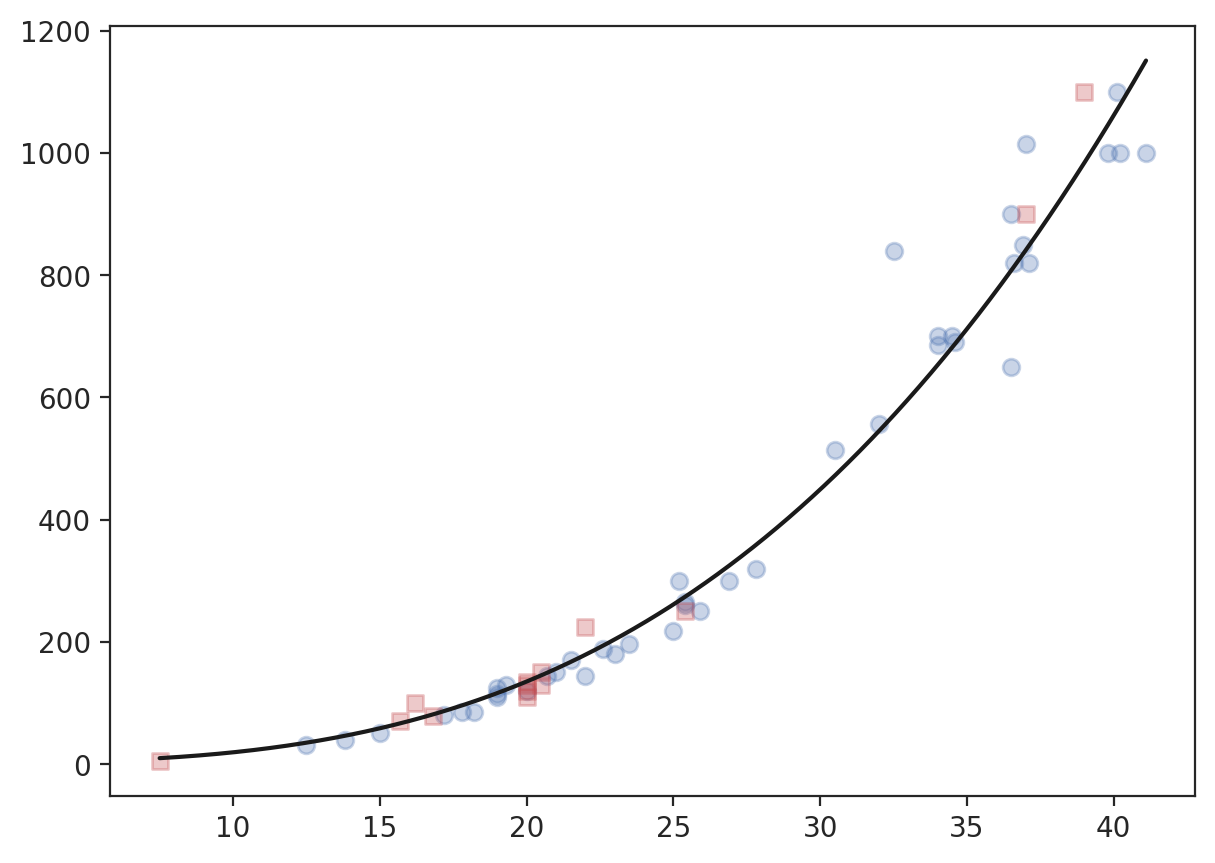

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train, y_train, alpha=0.3, marker='o', c='b')
ax.scatter(X_test, y_test, alpha=0.3, marker='s', c='r')
ax.plot(x_pred_range['length_cm'], poly_reg.predict(x_pred_range), c='k');

#### Cross-Validated Error

In [ ]:
eval_results = cross_validate(
    normal_reg, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

In [ ]:
-eval_results['test_score'].mean(), eval_results['test_score'].std()

(120.18293411346299, 53.88906375975307)

In [ ]:
-eval_results['train_score'].mean(), eval_results['train_score'].std()

(71.19034982820583, 9.662935075108617)

In [ ]:
eval_results = cross_validate(
    poly_reg, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

In [ ]:
-eval_results['test_score'].mean(), eval_results['test_score'].std()

(42.628546519292165, 38.6104246130769)

In [ ]:
-eval_results['train_score'].mean(), eval_results['train_score'].std()

(34.1236769998564, 6.940558951884383)

#### Model Properties

In [ ]:
normal_reg['est'].coef_

array([40.28731951])

In [ ]:
poly_reg['est'].coef_

array([0.01653667])

## Advertisement Data and Interaction Features

* Key idea: in addition to the individual effects of features $x_1$ and $x_2$, there might be an extra effect from the synergy of $x_1$ and $x_2$...
    - Example: ice cream sales and temperature/humidity


* Typically, interaction features modelled as the product of two features

### Dataset

In [ ]:
adv = pd.read_csv(
    'https://raw.githubusercontent.com/gerberl/6G7V0017-2324/main/datasets/Advertising.csv',
    index_col=0
)
adv.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [ ]:
adv_target = 'sales'
X, y = adv.drop(columns=adv_target), adv[adv_target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

### With and Without Interaction Features

In [ ]:
normal_reg = Pipeline(
    steps=[
        ('est', LinearRegression())
    ]
)

poly_reg = Pipeline(
    steps=[
        ('poly', PolynomialFeatures(
            interaction_only=True, include_bias=False)
        ),
        ('est', LinearRegression())
    ]
)

In [ ]:
poly_reg['poly'].fit_transform(X_train).head()

,TV,radio,newspaper,TV radio,TV newspaper,radio newspaper
135,36.9,38.6,65.6,1424.34,2420.64,2532.16
67,31.5,24.6,2.2,774.90,69.30,54.12
27,142.9,29.3,12.6,4186.97,1800.54,369.18
114,209.6,20.6,10.7,4317.76,2242.72,220.42
169,215.4,23.6,57.6,5083.44,12407.04,1359.36


In [ ]:
normal_reg.fit(X_train, y_train)

Pipeline(steps=[('est', Ridge())])

In [ ]:
poly_reg.fit(X_train, y_train)

Pipeline(steps=[('poly',
                 PolynomialFeatures(include_bias=False, interaction_only=True)),
                ('est', Ridge())])

In [ ]:
eval_results = cross_validate(
    normal_reg, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

In [ ]:
-eval_results['test_score'].mean(), eval_results['test_score'].std()

(1.3050375267658398, 0.21828718329392693)

In [ ]:
-eval_results['train_score'].mean(), eval_results['train_score'].std()

(1.2460516843275147, 0.07234804588253531)

In [ ]:
eval_results = cross_validate(
    poly_reg, X, y, cv=5,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

In [ ]:
-eval_results['test_score'].mean(), eval_results['test_score'].std()

(0.7083610960308062, 0.10389728937343569)

In [ ]:
-eval_results['train_score'].mean(), eval_results['train_score'].std()

(0.6600616584606842, 0.04562474255347637)

In [ ]:
normal_reg['est'].coef_

array([ 0.04458399,  0.19649066, -0.00278   ])

In [ ]:
poly_reg['est'].coef_

array([ 2.02401246e-02,  3.62650151e-02,  1.75188821e-02,  1.09361596e-03,
       -6.49896311e-05, -2.08547036e-04])

In [ ]:
poly_reg['poly'].get_feature_names_out()

array(['TV', 'radio', 'newspaper', 'TV radio', 'TV newspaper',
       'radio newspaper'], dtype=object)

Interaction features are generated as well; no straight-forward way to switch them off with `PolynomialFeatures`.

## Degrees and Under/Overfitting

In [ ]:
# draw your own data at https://drawdata.xyz/ - what a nice little tool
df = pd.read_csv(
    'https://raw.githubusercontent.com/gerberl/6g7v0015-2122/main/datasets/drawn-scatter.csv'
)
df = df.drop(columns='z')
df.head()

,x,y
0,35.950482,79.431157
1,-11.124807,-10.846584
2,12.877262,44.755818
3,25.965594,25.635648
4,46.374606,-11.708807


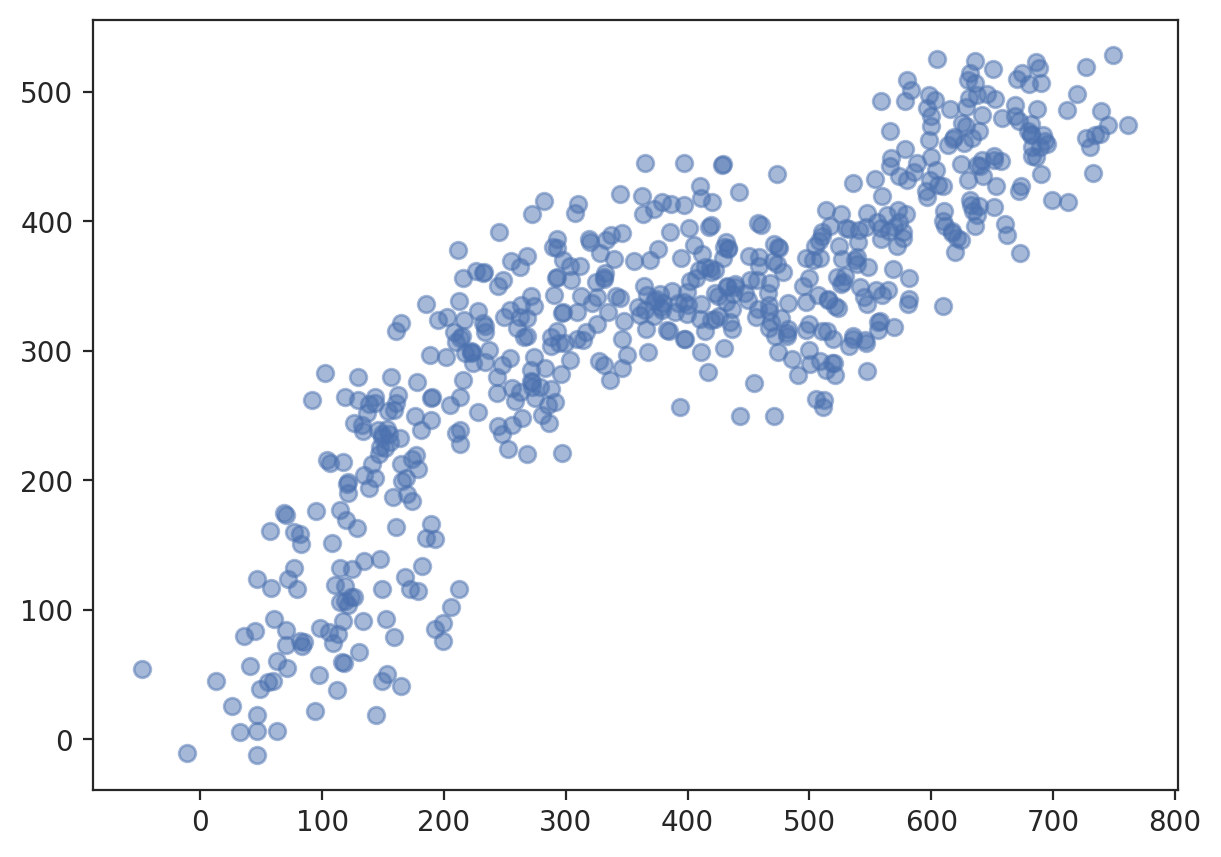

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(df['x'], df['y'], alpha=0.5);

In [ ]:
target = 'y'
X, y = df.drop(columns=target), df[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, random_state=0
)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((465, 1), (465,), (117, 1), (117,))

In [ ]:
# for plotting the model prediction, a large number of test data points
# only one feature: `x`
x_pred_range = pd.DataFrame(
    np.linspace(df['x'].min(), df['x'].max(), 1000),
    columns=['x']
)

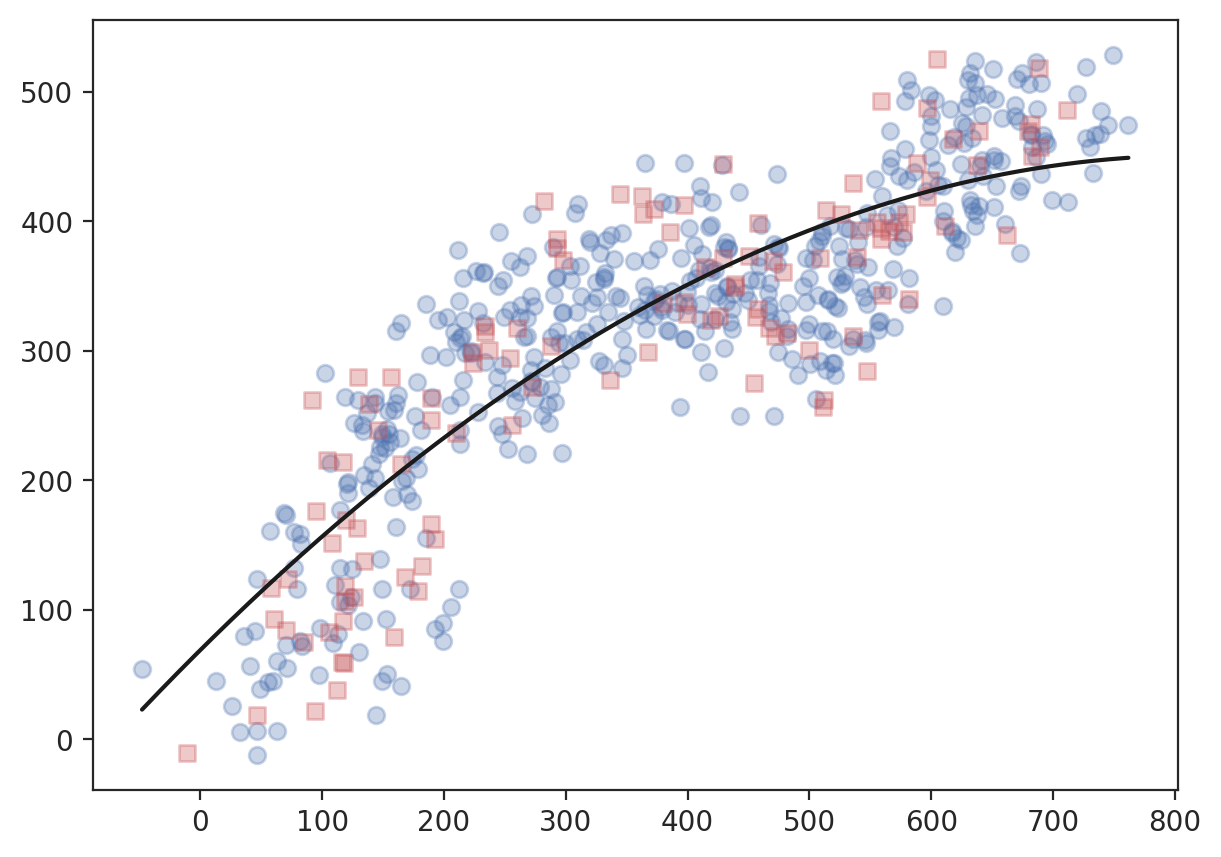

In [ ]:
model = make_pipeline(
    PolynomialFeatures(2, include_bias=False),
    LinearRegression()
)
model.fit(X_train, y_train)
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(X_train, y_train, alpha=0.3, marker='o', c='b')
ax.scatter(X_test, y_test, alpha=0.3, marker='s', c='r')
ax.plot(x_pred_range['x'], model.predict(x_pred_range), c='k');

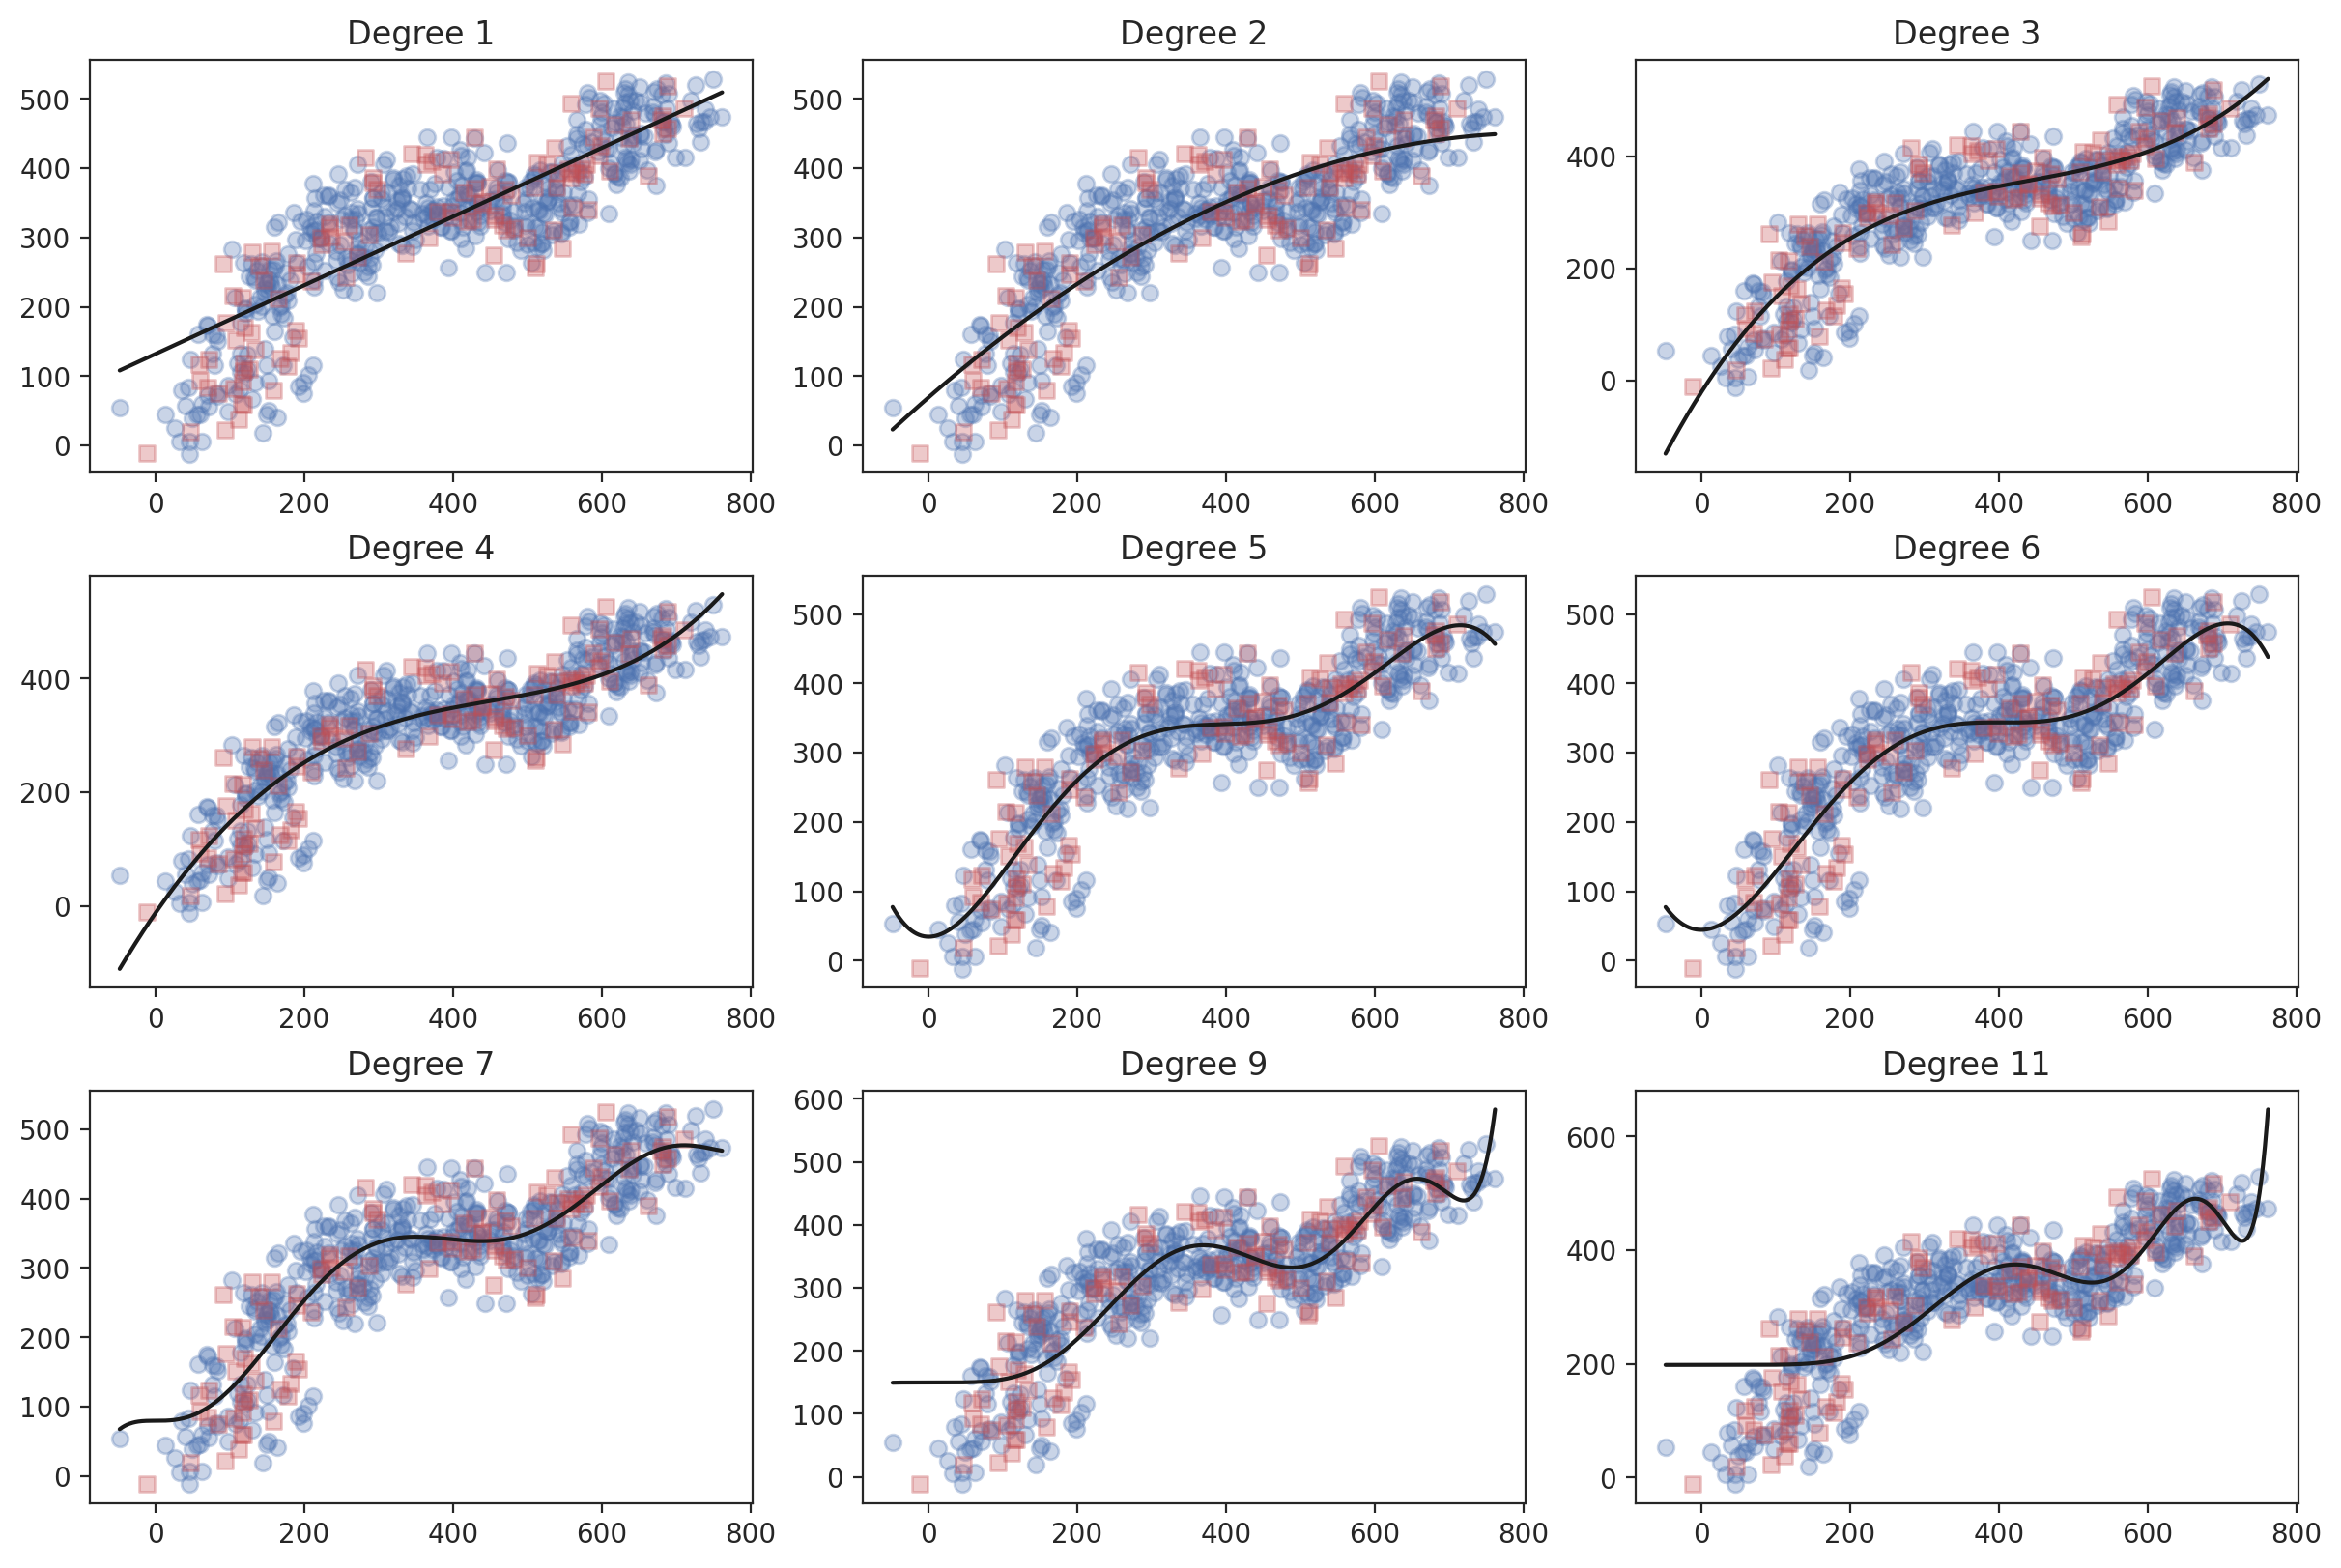

In [ ]:
orders = [1,2,3,4,5,6,7,9,11]
fig, axs = plt.subplots(3, 3, figsize=(12,8), constrained_layout=True)
lr_models = [ ]
for ax, order in zip(axs.ravel(), orders):
    model = make_pipeline(
        PolynomialFeatures(degree=order, include_bias=False),
        LinearRegression()
    )
    lr_models.append(
        model.fit(X_train, y_train)
    )
    ax.scatter(X_train, y_train, alpha=0.3, marker='o', c='b');
    ax.scatter(X_test, y_test, alpha=0.3, marker='s', c='r')
    ax.plot(x_pred_range['x'], model.predict(x_pred_range), c='k')
    ax.set_title(f'Degree {order}')

In [ ]:
for lr in lr_models:
    print(lr.score(X_test, y_test))

0.7209234286743841
0.7627216778334592
0.7907926165301855
0.7930710531224926
0.8076262718335991
0.8106296987222643
0.8138993113325463
0.7959908282714077
0.6857843709210772
